In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = 3


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                             | 0/60000 [00:00<?, ?it/s]

 11%|██████▉                                                        | 6614/60000 [00:00<00:00, 66132.02it/s]

 22%|█████████████▉                                                | 13466/60000 [00:00<00:00, 67532.80it/s]

 34%|████████████████████▉                                         | 20295/60000 [00:00<00:00, 67877.53it/s]

 45%|███████████████████████████▉                                  | 27083/60000 [00:00<00:00, 67849.60it/s]

 57%|███████████████████████████████████                           | 33940/60000 [00:00<00:00, 68107.81it/s]

 68%|██████████████████████████████████████████                    | 40751/60000 [00:00<00:00, 67759.15it/s]

 79%|█████████████████████████████████████████████████             | 47540/60000 [00:00<00:00, 67800.05it/s]

 91%|████████████████████████████████████████████████████████▏     | 54326/60000 [00:00<00:00, 67817.67it/s]

100%|██████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 67585.71it/s]

  0%|                                                                             | 0/10000 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████▊                    | 6800/10000 [00:00<00:00, 67993.09it/s]

100%|██████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 66902.38it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
model_ids = {
    "0:1:2:3:4": '59ftut3f',
    "5:6:7:8:9": "lz2g3fq1",
    "0": "cpnxtpv2",
    "1": "c6sohudf",
    "2": "5qeniujh",
    "3": "cto6ipr0",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

3 cto6ipr0


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                               | 0/674 [00:00<?, ?it/s]

  0%|                                                                       | 1/674 [00:01<11:28,  1.02s/it]

  1%|▍                                                                      | 4/674 [00:01<02:29,  4.49it/s]

  1%|▊                                                                      | 8/674 [00:01<01:11,  9.38it/s]

  2%|█▏                                                                    | 12/674 [00:01<00:46, 14.24it/s]

  2%|█▋                                                                    | 16/674 [00:01<00:35, 18.69it/s]

  3%|██                                                                    | 20/674 [00:01<00:29, 22.40it/s]

  4%|██▍                                                                   | 24/674 [00:01<00:25, 25.57it/s]

  4%|██▉                                                                   | 28/674 [00:01<00:23, 28.05it/s]

  5%|███▎                                                                  | 32/674 [00:01<00:21, 29.92it/s]

  5%|███▋                                                                  | 36/674 [00:02<00:20, 31.32it/s]

  6%|████▏                                                                 | 40/674 [00:02<00:19, 32.24it/s]

  7%|████▌                                                                 | 44/674 [00:02<00:19, 32.94it/s]

  7%|████▉                                                                 | 48/674 [00:02<00:18, 33.42it/s]

  8%|█████▍                                                                | 52/674 [00:02<00:18, 33.77it/s]

  8%|█████▊                                                                | 56/674 [00:02<00:18, 34.02it/s]

  9%|██████▏                                                               | 60/674 [00:02<00:17, 34.19it/s]

  9%|██████▋                                                               | 64/674 [00:02<00:17, 34.26it/s]

 10%|███████                                                               | 68/674 [00:02<00:17, 34.55it/s]

 11%|███████▍                                                              | 72/674 [00:03<00:17, 34.67it/s]

 11%|███████▉                                                              | 76/674 [00:03<00:17, 34.59it/s]

 12%|████████▎                                                             | 80/674 [00:03<00:17, 34.57it/s]

 12%|████████▋                                                             | 84/674 [00:03<00:17, 34.58it/s]

 13%|█████████▏                                                            | 88/674 [00:03<00:17, 34.44it/s]

 14%|█████████▌                                                            | 92/674 [00:03<00:16, 34.55it/s]

 14%|█████████▉                                                            | 96/674 [00:03<00:16, 34.57it/s]

 15%|██████████▏                                                          | 100/674 [00:03<00:16, 34.39it/s]

 15%|██████████▋                                                          | 104/674 [00:04<00:16, 34.58it/s]

 16%|███████████                                                          | 108/674 [00:04<00:16, 34.66it/s]

 17%|███████████▍                                                         | 112/674 [00:04<00:16, 34.67it/s]

 17%|███████████▉                                                         | 116/674 [00:04<00:16, 34.76it/s]

 18%|████████████▎                                                        | 120/674 [00:04<00:16, 34.62it/s]

 18%|████████████▋                                                        | 124/674 [00:04<00:15, 34.70it/s]

 19%|█████████████                                                        | 128/674 [00:04<00:15, 34.59it/s]

 20%|█████████████▌                                                       | 132/674 [00:04<00:15, 34.54it/s]

 20%|█████████████▉                                                       | 136/674 [00:04<00:15, 34.51it/s]

 21%|██████████████▎                                                      | 140/674 [00:05<00:15, 34.64it/s]

 21%|██████████████▋                                                      | 144/674 [00:05<00:15, 34.57it/s]

 22%|███████████████▏                                                     | 148/674 [00:05<00:15, 34.61it/s]

 23%|███████████████▌                                                     | 152/674 [00:05<00:15, 34.70it/s]

 23%|███████████████▉                                                     | 156/674 [00:05<00:14, 34.75it/s]

 24%|████████████████▍                                                    | 160/674 [00:05<00:14, 34.82it/s]

 24%|████████████████▊                                                    | 164/674 [00:05<00:14, 34.75it/s]

 25%|█████████████████▏                                                   | 168/674 [00:05<00:14, 34.76it/s]

 26%|█████████████████▌                                                   | 172/674 [00:05<00:14, 34.78it/s]

 26%|██████████████████                                                   | 176/674 [00:06<00:14, 34.76it/s]

 27%|██████████████████▍                                                  | 180/674 [00:06<00:14, 34.69it/s]

 27%|██████████████████▊                                                  | 184/674 [00:06<00:14, 34.47it/s]

 28%|███████████████████▏                                                 | 188/674 [00:06<00:14, 34.41it/s]

 28%|███████████████████▋                                                 | 192/674 [00:06<00:14, 34.42it/s]

 29%|████████████████████                                                 | 196/674 [00:06<00:13, 34.48it/s]

 30%|████████████████████▍                                                | 200/674 [00:06<00:13, 34.62it/s]

 30%|████████████████████▉                                                | 204/674 [00:06<00:13, 34.70it/s]

 31%|█████████████████████▎                                               | 208/674 [00:07<00:13, 34.70it/s]

 31%|█████████████████████▋                                               | 212/674 [00:07<00:13, 34.61it/s]

 32%|██████████████████████                                               | 216/674 [00:07<00:13, 34.56it/s]

 33%|██████████████████████▌                                              | 220/674 [00:07<00:13, 34.50it/s]

 33%|██████████████████████▉                                              | 224/674 [00:07<00:13, 34.47it/s]

 34%|███████████████████████▎                                             | 228/674 [00:07<00:12, 34.47it/s]

 34%|███████████████████████▊                                             | 232/674 [00:07<00:12, 34.43it/s]

 35%|████████████████████████▏                                            | 236/674 [00:07<00:12, 34.46it/s]

 36%|████████████████████████▌                                            | 240/674 [00:07<00:12, 34.45it/s]

 36%|████████████████████████▉                                            | 244/674 [00:08<00:12, 34.61it/s]

 37%|█████████████████████████▍                                           | 248/674 [00:08<00:12, 34.68it/s]

 37%|█████████████████████████▊                                           | 252/674 [00:08<00:12, 34.70it/s]

 38%|██████████████████████████▏                                          | 256/674 [00:08<00:12, 34.71it/s]

 39%|██████████████████████████▌                                          | 260/674 [00:08<00:11, 34.75it/s]

 39%|███████████████████████████                                          | 264/674 [00:08<00:11, 34.70it/s]

 40%|███████████████████████████▍                                         | 268/674 [00:08<00:11, 34.71it/s]

 40%|███████████████████████████▊                                         | 272/674 [00:08<00:11, 34.62it/s]

 41%|████████████████████████████▎                                        | 276/674 [00:08<00:11, 34.54it/s]

 42%|████████████████████████████▋                                        | 280/674 [00:09<00:11, 34.43it/s]

 42%|█████████████████████████████                                        | 284/674 [00:09<00:11, 34.55it/s]

 43%|█████████████████████████████▍                                       | 288/674 [00:09<00:11, 34.64it/s]

 43%|█████████████████████████████▉                                       | 292/674 [00:09<00:11, 34.66it/s]

 44%|██████████████████████████████▎                                      | 296/674 [00:09<00:10, 34.60it/s]

 45%|██████████████████████████████▋                                      | 300/674 [00:09<00:10, 34.57it/s]

 45%|███████████████████████████████                                      | 304/674 [00:09<00:10, 34.50it/s]

 46%|███████████████████████████████▌                                     | 308/674 [00:09<00:10, 34.53it/s]

 46%|███████████████████████████████▉                                     | 312/674 [00:10<00:10, 34.60it/s]

 47%|████████████████████████████████▎                                    | 316/674 [00:10<00:10, 34.63it/s]

 47%|████████████████████████████████▊                                    | 320/674 [00:10<00:10, 34.68it/s]

 48%|█████████████████████████████████▏                                   | 324/674 [00:10<00:10, 34.74it/s]

 49%|█████████████████████████████████▌                                   | 328/674 [00:10<00:09, 34.75it/s]

 49%|█████████████████████████████████▉                                   | 332/674 [00:10<00:09, 34.76it/s]

 50%|██████████████████████████████████▍                                  | 336/674 [00:10<00:09, 34.73it/s]

 50%|██████████████████████████████████▊                                  | 340/674 [00:10<00:09, 34.74it/s]

 51%|███████████████████████████████████▏                                 | 344/674 [00:10<00:09, 34.74it/s]

 52%|███████████████████████████████████▋                                 | 348/674 [00:11<00:09, 34.73it/s]

 52%|████████████████████████████████████                                 | 352/674 [00:11<00:09, 34.75it/s]

 53%|████████████████████████████████████▍                                | 356/674 [00:11<00:09, 34.61it/s]

 53%|████████████████████████████████████▊                                | 360/674 [00:11<00:09, 34.51it/s]

 54%|█████████████████████████████████████▎                               | 364/674 [00:11<00:08, 34.55it/s]

 55%|█████████████████████████████████████▋                               | 368/674 [00:11<00:08, 34.65it/s]

 55%|██████████████████████████████████████                               | 372/674 [00:11<00:08, 34.66it/s]

 56%|██████████████████████████████████████▍                              | 376/674 [00:11<00:08, 34.65it/s]

 56%|██████████████████████████████████████▉                              | 380/674 [00:11<00:08, 34.68it/s]

 57%|███████████████████████████████████████▎                             | 384/674 [00:12<00:08, 34.64it/s]

 58%|███████████████████████████████████████▋                             | 388/674 [00:12<00:08, 34.70it/s]

 58%|████████████████████████████████████████▏                            | 392/674 [00:12<00:08, 34.64it/s]

 59%|████████████████████████████████████████▌                            | 396/674 [00:12<00:08, 34.52it/s]

 59%|████████████████████████████████████████▉                            | 400/674 [00:12<00:07, 34.46it/s]

 60%|█████████████████████████████████████████▎                           | 404/674 [00:12<00:07, 34.37it/s]

 61%|█████████████████████████████████████████▊                           | 408/674 [00:12<00:07, 34.40it/s]

 61%|██████████████████████████████████████████▏                          | 412/674 [00:12<00:07, 34.26it/s]

 62%|██████████████████████████████████████████▌                          | 416/674 [00:13<00:07, 34.39it/s]

 62%|██████████████████████████████████████████▉                          | 420/674 [00:13<00:07, 34.56it/s]

 63%|███████████████████████████████████████████▍                         | 424/674 [00:13<00:07, 34.65it/s]

 64%|███████████████████████████████████████████▊                         | 428/674 [00:13<00:07, 34.73it/s]

 64%|████████████████████████████████████████████▏                        | 432/674 [00:13<00:06, 34.77it/s]

 65%|████████████████████████████████████████████▋                        | 436/674 [00:13<00:06, 34.80it/s]

 65%|█████████████████████████████████████████████                        | 440/674 [00:13<00:06, 34.82it/s]

 66%|█████████████████████████████████████████████▍                       | 444/674 [00:13<00:06, 34.67it/s]

 66%|█████████████████████████████████████████████▊                       | 448/674 [00:13<00:06, 34.73it/s]

 67%|██████████████████████████████████████████████▎                      | 452/674 [00:14<00:06, 34.74it/s]

 68%|██████████████████████████████████████████████▋                      | 456/674 [00:14<00:06, 34.59it/s]

 68%|███████████████████████████████████████████████                      | 460/674 [00:14<00:06, 34.64it/s]

 69%|███████████████████████████████████████████████▌                     | 464/674 [00:14<00:06, 34.66it/s]

 69%|███████████████████████████████████████████████▉                     | 468/674 [00:14<00:05, 34.72it/s]

 70%|████████████████████████████████████████████████▎                    | 472/674 [00:14<00:05, 34.67it/s]

 71%|████████████████████████████████████████████████▋                    | 476/674 [00:14<00:05, 34.69it/s]

 71%|█████████████████████████████████████████████████▏                   | 480/674 [00:14<00:05, 34.72it/s]

 72%|█████████████████████████████████████████████████▌                   | 484/674 [00:14<00:05, 34.76it/s]

 72%|█████████████████████████████████████████████████▉                   | 488/674 [00:15<00:05, 34.77it/s]

 73%|██████████████████████████████████████████████████▎                  | 492/674 [00:15<00:05, 34.76it/s]

 74%|██████████████████████████████████████████████████▊                  | 496/674 [00:15<00:05, 34.79it/s]

 74%|███████████████████████████████████████████████████▏                 | 500/674 [00:15<00:05, 34.77it/s]

 75%|███████████████████████████████████████████████████▌                 | 504/674 [00:15<00:04, 34.73it/s]

 75%|████████████████████████████████████████████████████                 | 508/674 [00:15<00:04, 34.67it/s]

 76%|████████████████████████████████████████████████████▍                | 512/674 [00:15<00:04, 34.62it/s]

 77%|████████████████████████████████████████████████████▊                | 516/674 [00:15<00:04, 34.60it/s]

 77%|█████████████████████████████████████████████████████▏               | 520/674 [00:16<00:04, 34.43it/s]

 78%|█████████████████████████████████████████████████████▋               | 524/674 [00:16<00:04, 34.32it/s]

 78%|██████████████████████████████████████████████████████               | 528/674 [00:16<00:04, 34.29it/s]

 79%|██████████████████████████████████████████████████████▍              | 532/674 [00:16<00:04, 34.11it/s]

 80%|██████████████████████████████████████████████████████▊              | 536/674 [00:16<00:04, 34.14it/s]

 80%|███████████████████████████████████████████████████████▎             | 540/674 [00:16<00:03, 34.14it/s]

 81%|███████████████████████████████████████████████████████▋             | 544/674 [00:16<00:03, 34.18it/s]

 81%|████████████████████████████████████████████████████████             | 548/674 [00:16<00:03, 34.18it/s]

 82%|████████████████████████████████████████████████████████▌            | 552/674 [00:16<00:03, 34.21it/s]

 82%|████████████████████████████████████████████████████████▉            | 556/674 [00:17<00:03, 34.24it/s]

 83%|█████████████████████████████████████████████████████████▎           | 560/674 [00:17<00:03, 34.28it/s]

 84%|█████████████████████████████████████████████████████████▋           | 564/674 [00:17<00:03, 34.28it/s]

 84%|██████████████████████████████████████████████████████████▏          | 568/674 [00:17<00:03, 34.44it/s]

 85%|██████████████████████████████████████████████████████████▌          | 572/674 [00:17<00:02, 34.47it/s]

 85%|██████████████████████████████████████████████████████████▉          | 576/674 [00:17<00:02, 34.52it/s]

 86%|███████████████████████████████████████████████████████████▍         | 580/674 [00:17<00:02, 34.59it/s]

 87%|███████████████████████████████████████████████████████████▊         | 584/674 [00:17<00:02, 34.62it/s]

 87%|████████████████████████████████████████████████████████████▏        | 588/674 [00:18<00:02, 34.63it/s]

 88%|████████████████████████████████████████████████████████████▌        | 592/674 [00:18<00:02, 34.68it/s]

 88%|█████████████████████████████████████████████████████████████        | 596/674 [00:18<00:02, 34.74it/s]

 89%|█████████████████████████████████████████████████████████████▍       | 600/674 [00:18<00:02, 34.73it/s]

 90%|█████████████████████████████████████████████████████████████▊       | 604/674 [00:18<00:02, 34.73it/s]

 90%|██████████████████████████████████████████████████████████████▏      | 608/674 [00:18<00:01, 34.72it/s]

 91%|██████████████████████████████████████████████████████████████▋      | 612/674 [00:18<00:01, 34.77it/s]

 91%|███████████████████████████████████████████████████████████████      | 616/674 [00:18<00:01, 34.71it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 620/674 [00:18<00:01, 34.71it/s]

 93%|███████████████████████████████████████████████████████████████▉     | 624/674 [00:19<00:01, 34.65it/s]

 93%|████████████████████████████████████████████████████████████████▎    | 628/674 [00:19<00:01, 34.64it/s]

 94%|████████████████████████████████████████████████████████████████▋    | 632/674 [00:19<00:01, 34.70it/s]

 94%|█████████████████████████████████████████████████████████████████    | 636/674 [00:19<00:01, 34.72it/s]

 95%|█████████████████████████████████████████████████████████████████▌   | 640/674 [00:19<00:00, 34.76it/s]

 96%|█████████████████████████████████████████████████████████████████▉   | 644/674 [00:19<00:00, 34.56it/s]

 96%|██████████████████████████████████████████████████████████████████▎  | 648/674 [00:19<00:00, 34.55it/s]

 97%|██████████████████████████████████████████████████████████████████▋  | 652/674 [00:19<00:00, 34.58it/s]

 97%|███████████████████████████████████████████████████████████████████▏ | 656/674 [00:19<00:00, 34.47it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 660/674 [00:20<00:00, 34.49it/s]

 99%|███████████████████████████████████████████████████████████████████▉ | 664/674 [00:20<00:00, 34.56it/s]

 99%|████████████████████████████████████████████████████████████████████▍| 668/674 [00:20<00:00, 34.78it/s]

100%|████████████████████████████████████████████████████████████████████▊| 672/674 [00:20<00:00, 35.34it/s]

100%|█████████████████████████████████████████████████████████████████████| 674/674 [00:20<00:00, 32.76it/s]

train - OK


  0%|                                                                               | 0/169 [00:00<?, ?it/s]

  1%|▍                                                                      | 1/169 [00:00<00:23,  7.12it/s]

  3%|██                                                                     | 5/169 [00:00<00:07, 21.29it/s]

  5%|███▊                                                                   | 9/169 [00:00<00:05, 26.67it/s]

  8%|█████▍                                                                | 13/169 [00:00<00:05, 29.37it/s]

 10%|███████                                                               | 17/169 [00:00<00:04, 31.02it/s]

 12%|████████▋                                                             | 21/169 [00:00<00:04, 31.34it/s]

 15%|██████████▎                                                           | 25/169 [00:00<00:04, 32.17it/s]

 17%|████████████                                                          | 29/169 [00:00<00:04, 32.81it/s]

 20%|█████████████▋                                                        | 33/169 [00:01<00:04, 33.29it/s]

 22%|███████████████▎                                                      | 37/169 [00:01<00:03, 33.63it/s]

 24%|████████████████▉                                                     | 41/169 [00:01<00:03, 33.85it/s]

 27%|██████████████████▋                                                   | 45/169 [00:01<00:03, 33.93it/s]

 29%|████████████████████▎                                                 | 49/169 [00:01<00:03, 34.01it/s]

 31%|█████████████████████▉                                                | 53/169 [00:01<00:03, 34.05it/s]

 34%|███████████████████████▌                                              | 57/169 [00:01<00:03, 34.13it/s]

 36%|█████████████████████████▎                                            | 61/169 [00:01<00:03, 34.19it/s]

 38%|██████████████████████████▉                                           | 65/169 [00:02<00:03, 34.25it/s]

 41%|████████████████████████████▌                                         | 69/169 [00:02<00:02, 34.26it/s]

 43%|██████████████████████████████▏                                       | 73/169 [00:02<00:02, 34.22it/s]

 46%|███████████████████████████████▉                                      | 77/169 [00:02<00:02, 34.24it/s]

 48%|█████████████████████████████████▌                                    | 81/169 [00:02<00:02, 34.24it/s]

 50%|███████████████████████████████████▏                                  | 85/169 [00:02<00:02, 34.24it/s]

 53%|████████████████████████████████████▊                                 | 89/169 [00:02<00:02, 33.97it/s]

 55%|██████████████████████████████████████▌                               | 93/169 [00:02<00:02, 34.08it/s]

 57%|████████████████████████████████████████▏                             | 97/169 [00:02<00:02, 34.15it/s]

 60%|█████████████████████████████████████████▏                           | 101/169 [00:03<00:01, 34.21it/s]

 62%|██████████████████████████████████████████▊                          | 105/169 [00:03<00:01, 34.22it/s]

 64%|████████████████████████████████████████████▌                        | 109/169 [00:03<00:01, 34.23it/s]

 67%|██████████████████████████████████████████████▏                      | 113/169 [00:03<00:01, 34.31it/s]

 69%|███████████████████████████████████████████████▊                     | 117/169 [00:03<00:01, 34.27it/s]

 72%|█████████████████████████████████████████████████▍                   | 121/169 [00:03<00:01, 34.20it/s]

 74%|███████████████████████████████████████████████████                  | 125/169 [00:03<00:01, 34.19it/s]

 76%|████████████████████████████████████████████████████▋                | 129/169 [00:03<00:01, 34.19it/s]

 79%|██████████████████████████████████████████████████████▎              | 133/169 [00:04<00:01, 34.21it/s]

 81%|███████████████████████████████████████████████████████▉             | 137/169 [00:04<00:00, 34.23it/s]

 83%|█████████████████████████████████████████████████████████▌           | 141/169 [00:04<00:00, 34.23it/s]

 86%|███████████████████████████████████████████████████████████▏         | 145/169 [00:04<00:00, 34.21it/s]

 88%|████████████████████████████████████████████████████████████▊        | 149/169 [00:04<00:00, 34.18it/s]

 91%|██████████████████████████████████████████████████████████████▍      | 153/169 [00:04<00:00, 33.29it/s]

 93%|████████████████████████████████████████████████████████████████     | 157/169 [00:04<00:00, 33.50it/s]

 95%|█████████████████████████████████████████████████████████████████▋   | 161/169 [00:04<00:00, 33.69it/s]

 98%|███████████████████████████████████████████████████████████████████▎ | 165/169 [00:04<00:00, 34.56it/s]

100%|█████████████████████████████████████████████████████████████████████| 169/169 [00:05<00:00, 33.41it/s]

100%|█████████████████████████████████████████████████████████████████████| 169/169 [00:05<00:00, 33.03it/s]

val - OK


  0%|                                                                               | 0/141 [00:00<?, ?it/s]

  1%|▌                                                                      | 1/141 [00:00<00:20,  6.94it/s]

  4%|██▌                                                                    | 5/141 [00:00<00:06, 21.22it/s]

  6%|████▌                                                                  | 9/141 [00:00<00:04, 26.79it/s]

  9%|██████▍                                                               | 13/141 [00:00<00:04, 29.63it/s]

 12%|████████▍                                                             | 17/141 [00:00<00:03, 31.23it/s]

 15%|██████████▍                                                           | 21/141 [00:00<00:03, 32.33it/s]

 18%|████████████▍                                                         | 25/141 [00:00<00:03, 33.00it/s]

 21%|██████████████▍                                                       | 29/141 [00:00<00:03, 33.37it/s]

 23%|████████████████▍                                                     | 33/141 [00:01<00:03, 33.54it/s]

 26%|██████████████████▎                                                   | 37/141 [00:01<00:03, 33.77it/s]

 29%|████████████████████▎                                                 | 41/141 [00:01<00:02, 33.56it/s]

 32%|██████████████████████▎                                               | 45/141 [00:01<00:02, 32.32it/s]

 35%|████████████████████████▎                                             | 49/141 [00:01<00:02, 32.87it/s]

 38%|██████████████████████████▎                                           | 53/141 [00:01<00:02, 33.44it/s]

 40%|████████████████████████████▎                                         | 57/141 [00:01<00:02, 33.77it/s]

 43%|██████████████████████████████▎                                       | 61/141 [00:01<00:02, 33.93it/s]

 46%|████████████████████████████████▎                                     | 65/141 [00:02<00:02, 34.12it/s]

 49%|██████████████████████████████████▎                                   | 69/141 [00:02<00:02, 34.28it/s]

 52%|████████████████████████████████████▏                                 | 73/141 [00:02<00:01, 34.29it/s]

 55%|██████████████████████████████████████▏                               | 77/141 [00:02<00:01, 34.33it/s]

 57%|████████████████████████████████████████▏                             | 81/141 [00:02<00:01, 34.32it/s]

 60%|██████████████████████████████████████████▏                           | 85/141 [00:02<00:01, 34.24it/s]

 63%|████████████████████████████████████████████▏                         | 89/141 [00:02<00:01, 34.23it/s]

 66%|██████████████████████████████████████████████▏                       | 93/141 [00:02<00:01, 34.34it/s]

 69%|████████████████████████████████████████████████▏                     | 97/141 [00:02<00:01, 34.45it/s]

 72%|█████████████████████████████████████████████████▍                   | 101/141 [00:03<00:01, 34.57it/s]

 74%|███████████████████████████████████████████████████▍                 | 105/141 [00:03<00:01, 34.58it/s]

 77%|█████████████████████████████████████████████████████▎               | 109/141 [00:03<00:00, 34.47it/s]

 80%|███████████████████████████████████████████████████████▎             | 113/141 [00:03<00:00, 34.38it/s]

 83%|█████████████████████████████████████████████████████████▎           | 117/141 [00:03<00:00, 34.44it/s]

 86%|███████████████████████████████████████████████████████████▏         | 121/141 [00:03<00:00, 34.50it/s]

 89%|█████████████████████████████████████████████████████████████▏       | 125/141 [00:03<00:00, 34.56it/s]

 91%|███████████████████████████████████████████████████████████████▏     | 129/141 [00:03<00:00, 34.56it/s]

 94%|█████████████████████████████████████████████████████████████████    | 133/141 [00:04<00:00, 34.63it/s]

 97%|███████████████████████████████████████████████████████████████████  | 137/141 [00:04<00:00, 35.36it/s]

100%|█████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 33.81it/s]

100%|█████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 32.97it/s]

test InD - OK


  0%|                                                                               | 0/112 [00:00<?, ?it/s]

  1%|▋                                                                      | 1/112 [00:00<00:16,  6.91it/s]

  4%|███▏                                                                   | 5/112 [00:00<00:05, 20.48it/s]

  8%|█████▋                                                                 | 9/112 [00:00<00:03, 26.09it/s]

 12%|████████▏                                                             | 13/112 [00:00<00:03, 28.20it/s]

 15%|██████████▋                                                           | 17/112 [00:00<00:03, 30.24it/s]

 19%|█████████████▏                                                        | 21/112 [00:00<00:02, 31.26it/s]

 22%|███████████████▋                                                      | 25/112 [00:00<00:02, 32.10it/s]

 26%|██████████████████▏                                                   | 29/112 [00:00<00:02, 32.77it/s]

 29%|████████████████████▋                                                 | 33/112 [00:01<00:02, 33.12it/s]

 33%|███████████████████████▏                                              | 37/112 [00:01<00:02, 33.44it/s]

 37%|█████████████████████████▋                                            | 41/112 [00:01<00:02, 33.67it/s]

 40%|████████████████████████████▏                                         | 45/112 [00:01<00:01, 33.84it/s]

 44%|██████████████████████████████▋                                       | 49/112 [00:01<00:01, 33.88it/s]

 47%|█████████████████████████████████▏                                    | 53/112 [00:01<00:01, 34.01it/s]

 51%|███████████████████████████████████▋                                  | 57/112 [00:01<00:01, 34.11it/s]

 54%|██████████████████████████████████████▏                               | 61/112 [00:01<00:01, 34.18it/s]

 58%|████████████████████████████████████████▋                             | 65/112 [00:02<00:01, 34.24it/s]

 62%|███████████████████████████████████████████▏                          | 69/112 [00:02<00:01, 34.15it/s]

 65%|█████████████████████████████████████████████▋                        | 73/112 [00:02<00:01, 34.14it/s]

 69%|████████████████████████████████████████████████▏                     | 77/112 [00:02<00:01, 34.17it/s]

 72%|██████████████████████████████████████████████████▋                   | 81/112 [00:02<00:00, 34.14it/s]

 76%|█████████████████████████████████████████████████████▏                | 85/112 [00:02<00:00, 34.15it/s]

 79%|███████████████████████████████████████████████████████▋              | 89/112 [00:02<00:00, 34.17it/s]

 83%|██████████████████████████████████████████████████████████▏           | 93/112 [00:02<00:00, 34.18it/s]

 87%|████████████████████████████████████████████████████████████▋         | 97/112 [00:02<00:00, 34.07it/s]

 90%|██████████████████████████████████████████████████████████████▏      | 101/112 [00:03<00:00, 34.11it/s]

 94%|████████████████████████████████████████████████████████████████▋    | 105/112 [00:03<00:00, 34.26it/s]

 97%|███████████████████████████████████████████████████████████████████▏ | 109/112 [00:03<00:00, 35.08it/s]

100%|█████████████████████████████████████████████████████████████████████| 112/112 [00:03<00:00, 32.35it/s]

test OoD - OK


  0%|                                                                               | 0/100 [00:00<?, ?it/s]

  4%|██▊                                                                    | 4/100 [00:00<00:02, 35.69it/s]

  8%|█████▋                                                                 | 8/100 [00:00<00:02, 37.35it/s]

 12%|████████▍                                                             | 12/100 [00:00<00:02, 37.99it/s]

 16%|███████████▏                                                          | 16/100 [00:00<00:02, 38.34it/s]

 20%|██████████████                                                        | 20/100 [00:00<00:02, 38.58it/s]

 24%|████████████████▊                                                     | 24/100 [00:00<00:01, 38.67it/s]

 28%|███████████████████▌                                                  | 28/100 [00:00<00:01, 38.66it/s]

 32%|██████████████████████▍                                               | 32/100 [00:00<00:01, 38.68it/s]

 36%|█████████████████████████▏                                            | 36/100 [00:00<00:01, 38.75it/s]

 40%|████████████████████████████                                          | 40/100 [00:01<00:01, 38.67it/s]

 44%|██████████████████████████████▊                                       | 44/100 [00:01<00:01, 38.56it/s]

 48%|█████████████████████████████████▌                                    | 48/100 [00:01<00:01, 38.45it/s]

 52%|████████████████████████████████████▍                                 | 52/100 [00:01<00:01, 38.13it/s]

 56%|███████████████████████████████████████▏                              | 56/100 [00:01<00:01, 37.82it/s]

 60%|██████████████████████████████████████████                            | 60/100 [00:01<00:01, 37.72it/s]

 64%|████████████████████████████████████████████▊                         | 64/100 [00:01<00:00, 37.99it/s]

 68%|███████████████████████████████████████████████▌                      | 68/100 [00:01<00:00, 38.21it/s]

 72%|██████████████████████████████████████████████████▍                   | 72/100 [00:01<00:00, 38.43it/s]

 76%|█████████████████████████████████████████████████████▏                | 76/100 [00:01<00:00, 38.57it/s]

 80%|████████████████████████████████████████████████████████              | 80/100 [00:02<00:00, 38.56it/s]

 84%|██████████████████████████████████████████████████████████▊           | 84/100 [00:02<00:00, 38.64it/s]

 88%|█████████████████████████████████████████████████████████████▌        | 88/100 [00:02<00:00, 38.71it/s]

 92%|████████████████████████████████████████████████████████████████▍     | 92/100 [00:02<00:00, 38.73it/s]

 96%|███████████████████████████████████████████████████████████████████▏  | 96/100 [00:02<00:00, 38.72it/s]

100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.75it/s]

100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.39it/s]

test RnD - OK
(43095,) (43095,)
(10774,) (10774,)
(8990,) (8990,)
(7141,) (7141,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

7.273389 0.45712522
7.2679644 0.4472586
7.287735 0.44929123
7.385134 0.40821427
14.253046 0.77334166
11.434778 0.017808307
11.434962 0.017767988
11.434494 0.01799504
11.432864 0.018340955
27.44844 0.6425889


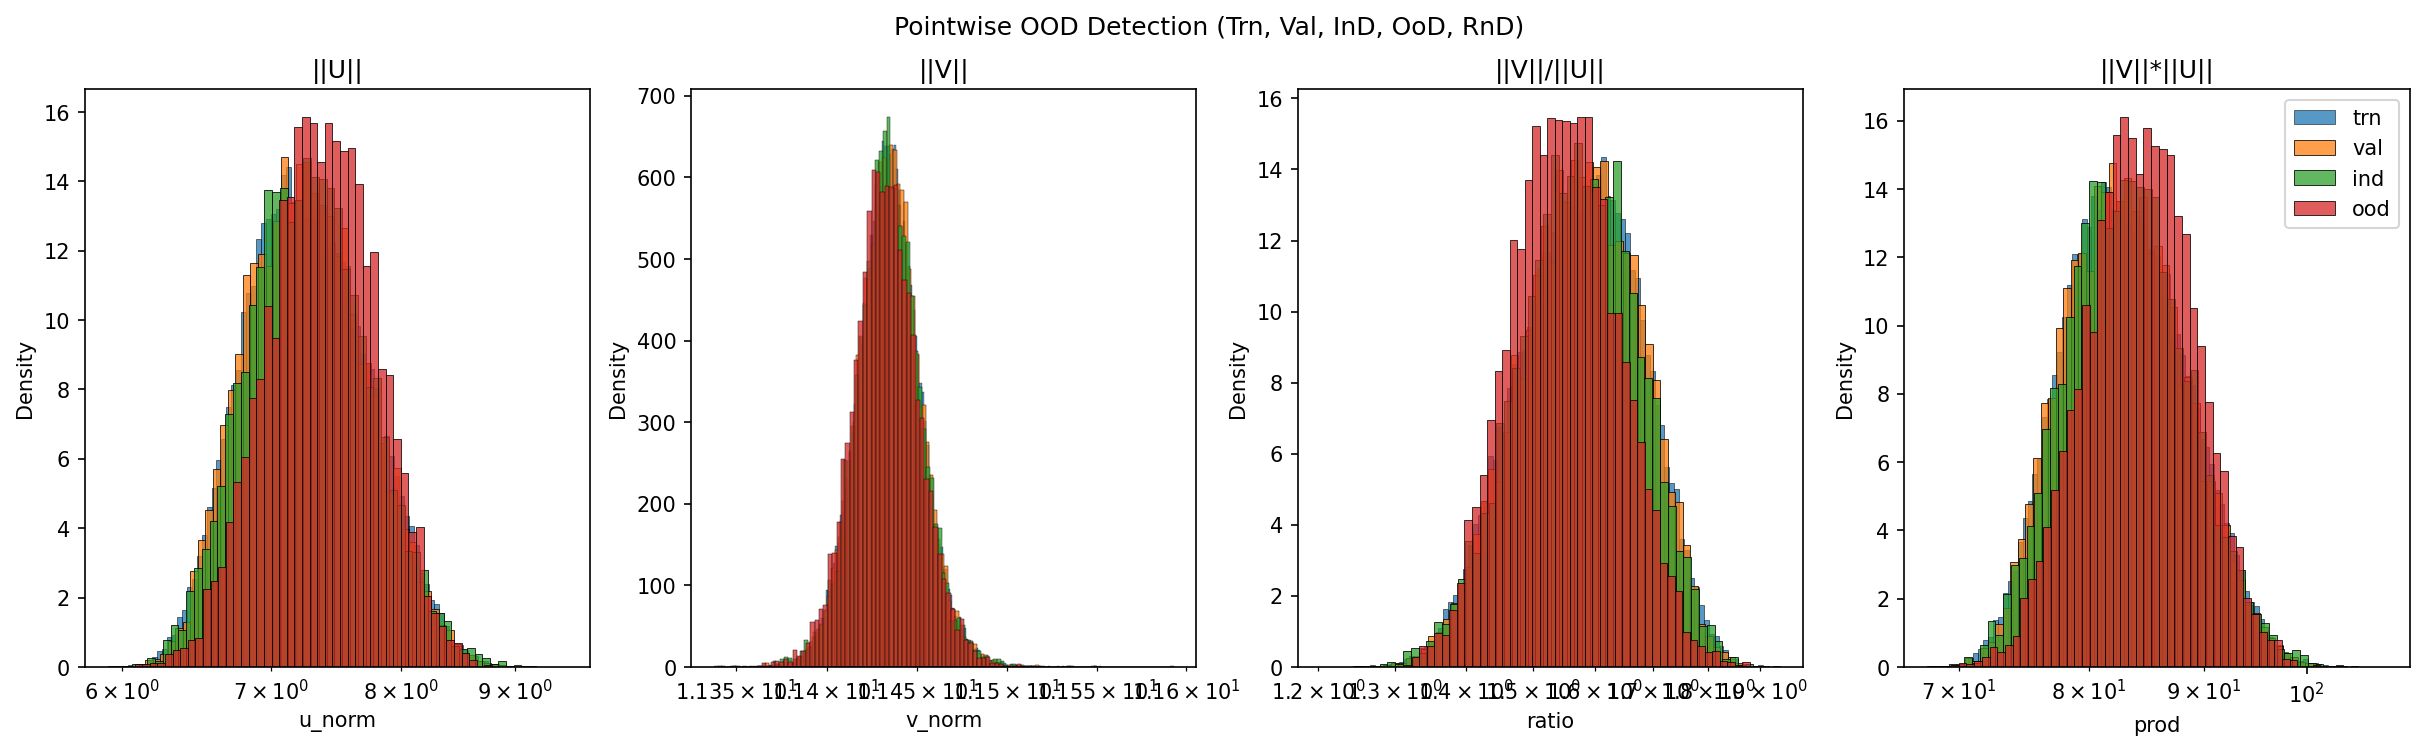

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 11.338186 11.552401 0.21421432
Val 11.342213 11.550214 0.20800114
Ind 11.37027 11.592755 0.22248554
Ood 11.340307 11.537004 0.19669724
Rnd 24.966032 30.282038 5.3160057
KstestResult(statistic=0.04619280879547036, pvalue=8.040620131071908e-08, statistic_location=11.427427, statistic_sign=-1)


[6 2 1 0 3 8 4 5 7 9]


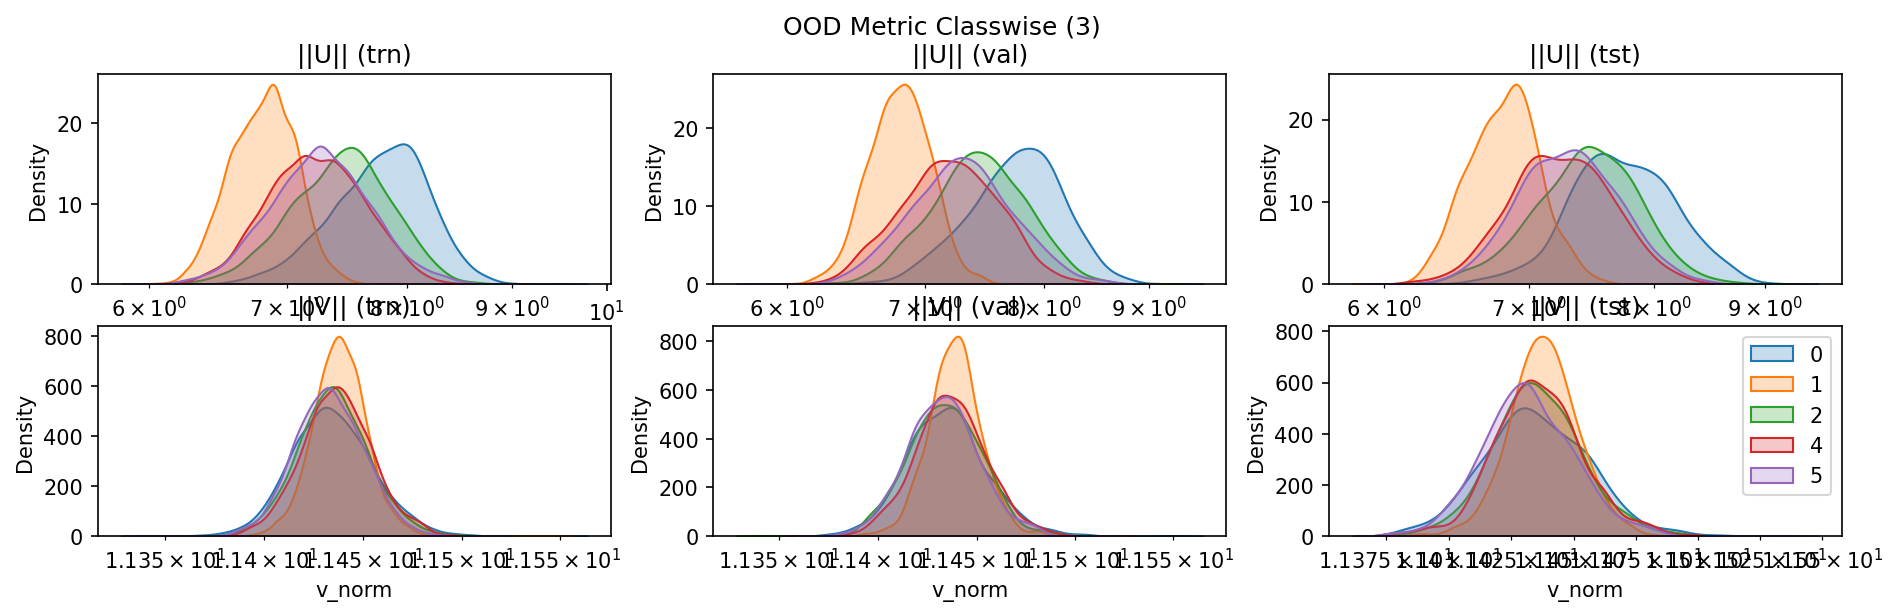

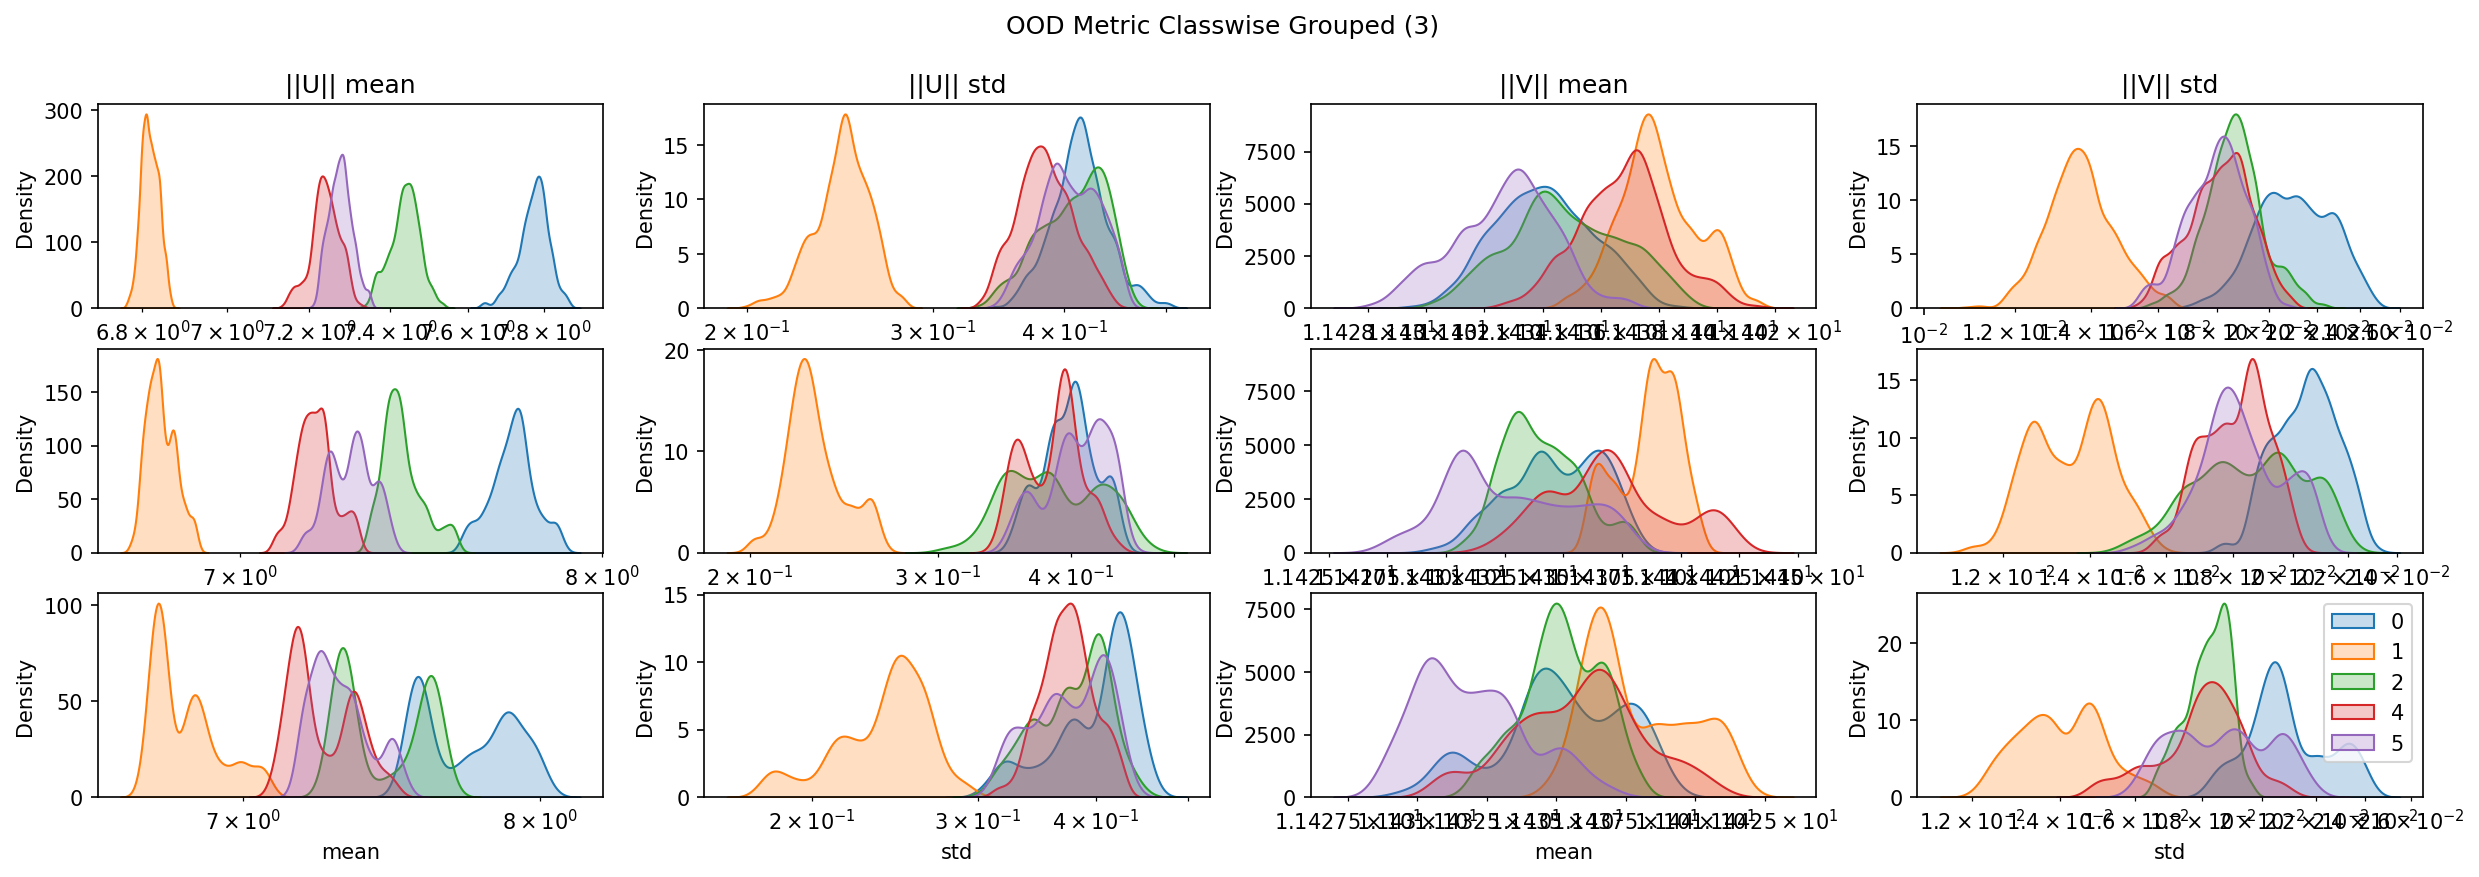

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)